In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
OUT_DIR = Path("~/simulation-outputs/ld-benchmarks/output-1589087").expanduser()

In [3]:
def melt_variable(df, var_name, sep, dtype):
    return (
        df[var_name]
        .str.split(sep, expand=True)
        .astype(dtype)
        .reset_index()
        .melt(id_vars="rep", value_name=var_name)
        .drop("variable", axis=1)
        .reset_index(drop=True)
    )


def gather_mode_data(df, variable, fixed_variable):
    add_columns = melt_variable(df, variable, "/", float).join(
        melt_variable(df, "seed", "-", int), rsuffix="seed"
    )
    assert (add_columns["rep"] == add_columns["repseed"]).all(), "bad join"
    add_columns.drop(["repseed"], axis=1, inplace=True)
    add_columns.set_index("rep", inplace=True)
    df = df.drop(["seed", variable], axis=1).join(add_columns)
    df[fixed_variable] = df[fixed_variable].astype(float)
    return df


def load_params(out_dir):
    data = []
    # we want the input data to be sorted for creating subreps
    files = sorted(
        (out_dir / "params").glob("*.json"),
        key=lambda f: int(f.name.split("_")[1].split(".")[0]),
    )
    for f in files:
        with open(f, "r") as fp:
            d = json.load(fp)
            assert d["mode"] in {"branch", "site"}
            site_mode = d["mode"] == "site"
            if site_mode:
                vars = d.pop("mu")
            else:
                vars = d.pop("r")
            seeds = d.pop("seeds")
            assert len(vars) == len(seeds)
            for var, seed in zip(vars, seeds):
                data.append(
                    {
                        **d,
                        "mu" if site_mode else "r": var,
                        "seed": seed,
                        "filename": f.name,
                    }
                )
    out = pd.DataFrame.from_dict(data)
    out["subrep"] = pd.Series(
        np.hstack([np.arange(c) for c in out.rep.value_counts(sort=False)])
    )
    assert (
        out.filename.str.split("_").str[1].str.split(".").str[0].astype(int) == out.rep
    ).all()
    for _, df in out.groupby("rep"):
        assert (df.subrep == np.arange(50)).all()
    return out

In [4]:
params = load_params(OUT_DIR)
result_dirs = OUT_DIR / "result" / (params.rep.drop_duplicates().astype(str) + ".npz")
# NB: small correction because I messed up my parameter generation script

In [5]:
def load_results(out_dir):
    timing_results = []
    tree_stats = []
    cpu_info = []
    job_info = []

    files = sorted(
        (out_dir / "result").glob("*.npz"),
        key=lambda f: int(f.name.split("_")[1].split(".")[0]),
    )
    for f in files:
        r = np.load(f)
        tree_stats.append(r["tree_stats"])
        timing_results.append(r["timing_result"].flatten())
        with open(f.with_suffix(".json"), "r") as fp:
            out_json = json.load(fp)
            cpu_info.append(out_json.pop("cpu_info"))
            job_info.append(out_json)
    timing_results = np.vstack(timing_results)
    tree_stats = pd.DataFrame(
        np.vstack(tree_stats),
        columns=["num_edges", "num_trees", "num_mutations", "num_sites"],
    )
    cpu_info = pd.DataFrame.from_dict(
        {
            i: {d["field"]: d["data"] for d in info["lscpu"]}
            for i, info in enumerate(cpu_info)
        },
        orient="index",
    ).rename(columns=lambda s: s.strip(":"))
    job_info = pd.DataFrame(job_info).assign(
        in_rep=lambda df: df.params.str.split("_").str[1].str.split(".").str[0].astype(int),
        out_rep=lambda df: df.out_prefix.str.split("_").str[1].astype(int),
    )
    return timing_results, tree_stats, cpu_info, job_info

In [6]:
timing_results, tree_stats, cpu_info, job_info = load_results(OUT_DIR)
assert np.prod(timing_results.shape) == len(params)
assert len(tree_stats) == len(params)
assert len(cpu_info) == len(params.rep.drop_duplicates())
assert len(params[["rep", "filename"]].drop_duplicates()) == len(cpu_info)

In [7]:
rep_map = job_info.set_index('in_rep').out_rep.to_dict()
params = params.assign(out_rep=lambda df: df.rep.map(rep_map)).sort_values(['out_rep', 'subrep'], ignore_index=True)
assert all([(df.subrep == np.arange(50)).all() for _, df in params.groupby('rep')])

In [8]:
# TODO: these masks are not great. the params should not dictate this, the output params should.
site = params["mode"] == "site"
branch = params["mode"] == "branch"
for mu, df in params[site].groupby("mu"):
    tree_stats.loc[df.index, "timing_result"] = timing_results[df.rep.map(rep_map), df.subrep]
for recomb, df in params[branch].groupby("r"):
    tree_stats.loc[df.index, "timing_result"] = timing_results[df.rep.map(rep_map), df.subrep]

In [9]:
timing_results

array([[1.66634761e-01, 1.46384254e-01, 2.51761401e+00, ...,
        2.72195830e+02, 2.32190859e+02, 2.58741725e+02],
       [6.29213671e-02, 5.93331789e-02, 1.06489224e+00, ...,
        1.15020148e+02, 1.16780577e+02, 1.19639462e+02],
       [1.68308921e-01, 1.33378968e-01, 2.69103491e+00, ...,
        2.73371523e+02, 2.71784599e+02, 2.73981217e+02],
       ...,
       [3.56722380e-01, 1.83070651e-01, 7.99398938e+00, ...,
        1.71500539e+03, 1.64979961e+03, 1.94748989e+03],
       [2.43023299e-01, 1.20578876e+01, 2.03393845e+01, ...,
        1.61723069e+03, 1.62332639e+03, 1.82349842e+03],
       [3.90116898e-01, 1.90007404e-01, 9.18530759e+00, ...,
        1.74276213e+03, 1.90341709e+03, 1.67299864e+03]])

In [10]:
tree_stats.head()

,num_edges,num_trees,num_mutations,num_sites,timing_result
0,95703,9279,302,294,0.166635
1,95369,9281,278,272,0.146384
2,94220,9270,1282,1196,2.517614
3,96886,9322,1294,1202,2.677347
4,95417,9295,2326,2077,8.081943


In [11]:
job_info.head()

,params,out_prefix,in_rep,out_rep
0,input_0.json,out_0,0,0
1,input_1.json,out_1,1,1
2,input_10.json,out_2,10,2
3,input_100.json,out_3,100,3
4,input_1000.json,out_4,1000,4


In [12]:
cpu_info.loc[
    :,
    ~cpu_info.columns.str.startswith("Vuln")
    & ~cpu_info.columns.str.startswith("NUMA")
    & ~cpu_info.columns.isin(
        {
            "CPU op-mode(s)",
            "Byte Order",
            "Address sizes",
            "On-line CPU(s) list",
            "Core(s) per socket",
            "Socket(s)",
        }
    ),
].head()

,Architecture,CPU(s),Thread(s) per core,Vendor ID,CPU family,Model,Model name,Stepping,CPU MHz,CPU max MHz,CPU min MHz,BogoMIPS,Virtualization,L1d cache,L1i cache,L2 cache,L3 cache,Flags
0,x86_64,40,2,GenuineIntel,6,62,Intel(R) Xeon(R) CPU E5-2670 v2 @ 2.50GHz,4,2899.932,3300.0000,1200.0000,4999.87,VT-x,640 KiB,640 KiB,5 MiB,50 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
1,x86_64,128,2,AuthenticAMD,23,49,AMD EPYC 7452 32-Core Processor,0,2345.765,NaN,NaN,4691.53,AMD-V,2 MiB,2 MiB,32 MiB,256 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
2,x86_64,32,2,GenuineIntel,6,45,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,7,3299.847,3800.0000,1200.0000,5800.19,VT-x,512 KiB,512 KiB,4 MiB,40 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
3,x86_64,40,2,GenuineIntel,6,62,Intel(R) Xeon(R) CPU E5-2670 v2 @ 2.50GHz,4,2899.932,3300.0000,1200.0000,5000.14,VT-x,640 KiB,640 KiB,5 MiB,50 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
4,x86_64,40,2,GenuineIntel,6,62,Intel(R) Xeon(R) CPU E5-2670 v2 @ 2.50GHz,4,2899.932,3300.0000,1200.0000,5000.28,VT-x,640 KiB,640 KiB,5 MiB,50 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...


In [13]:
cpu_info["Flags"].str.contains("sse2").all()

True

In [14]:
cpu_info["Flags"].str.contains("sse3").all()

True

In [15]:
cpu_info["Flags"].str.contains("sse4").all()

True

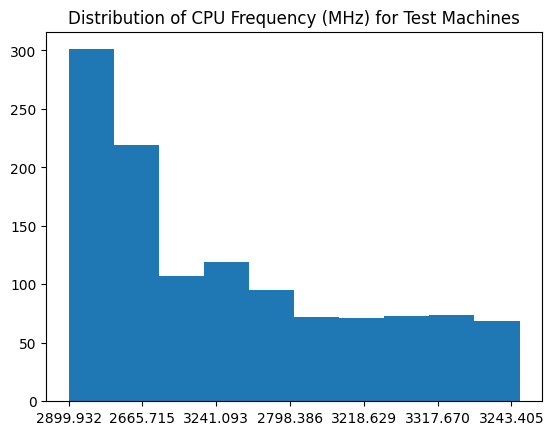

In [16]:
plt.hist(cpu_info["CPU MHz"])
[
    (label.set_visible(False), tick.set_visible(False))
    for i, (label, tick) in enumerate(
        zip(plt.gca().xaxis.get_ticklabels(), plt.gca().xaxis.get_major_ticks())
    )
    if i % 110
]
plt.title("Distribution of CPU Frequency (MHz) for Test Machines");

<Axes: >

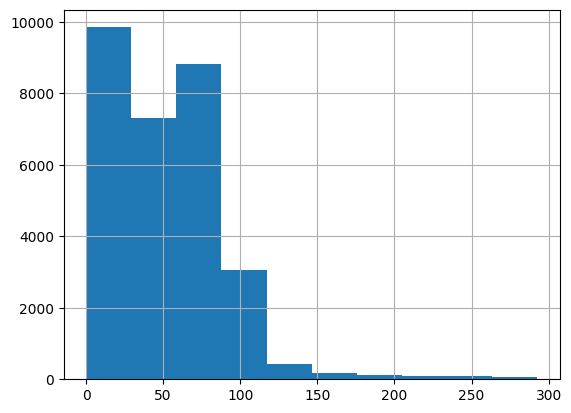

In [17]:
tree_stats[site].timing_result.hist()

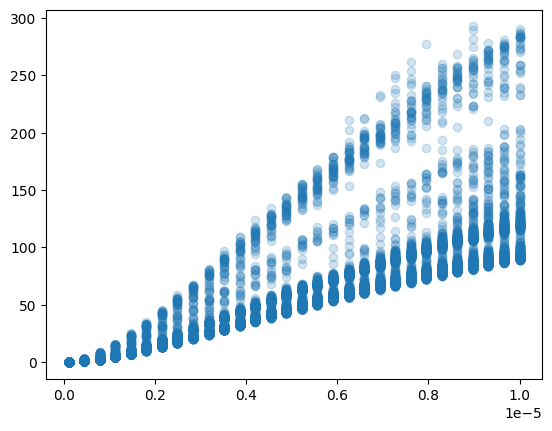

In [18]:
plt.scatter(params[site].mu, tree_stats[site].timing_result, alpha=0.2)

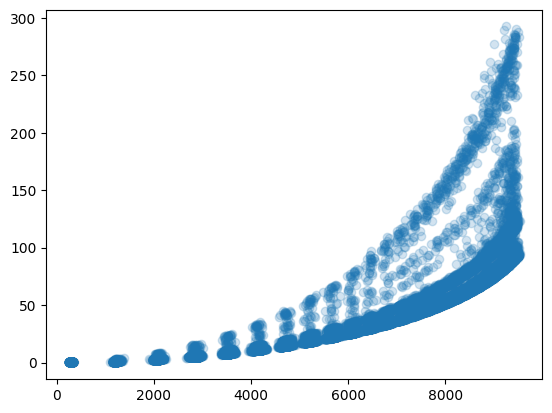

In [19]:
plt.scatter(tree_stats[site].num_sites, tree_stats[site].timing_result, alpha=0.2)

(array([9849., 7299., 8812., 3051.,  429.,  187.,  132.,   84.,  104.,
          53.]),
 array([3.93571199e-02, 2.92842360e+01, 5.85291149e+01, 8.77739938e+01,
        1.17018873e+02, 1.46263752e+02, 1.75508630e+02, 2.04753509e+02,
        2.33998388e+02, 2.63243267e+02, 2.92488146e+02]),
 <BarContainer object of 10 artists>)

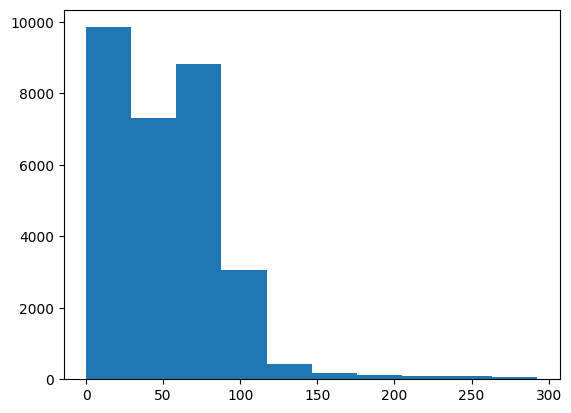

In [20]:
plt.hist(tree_stats[site].timing_result)

Text(0, 0.5, 'Num Sites')

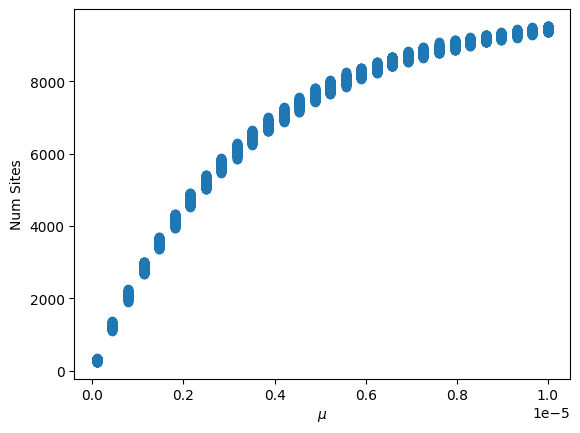

In [21]:
plt.scatter(params[site].mu, tree_stats[site].num_sites)
plt.xlabel(r"$\mu$")
plt.ylabel("Num Sites")

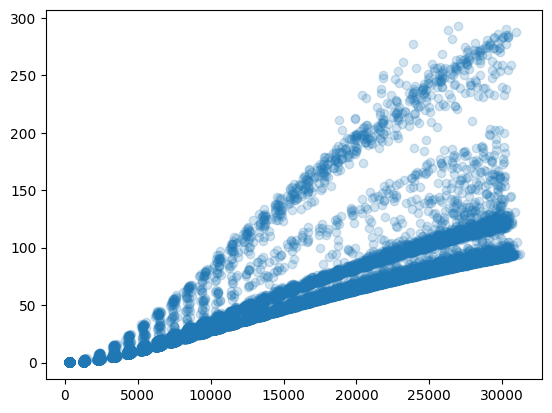

In [22]:
plt.scatter(tree_stats[site].num_mutations, tree_stats[site].timing_result, alpha=0.2)

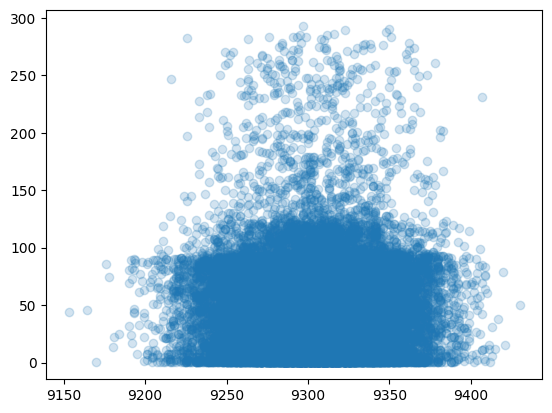

In [23]:
plt.scatter(tree_stats[site].num_trees, tree_stats[site].timing_result, alpha=0.2)

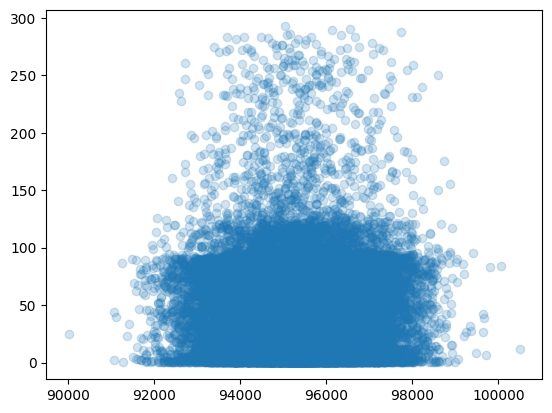

In [24]:
plt.scatter(tree_stats[site].num_edges, tree_stats[site].timing_result, alpha=0.2)

In [25]:
cpu_mhz = params[["rep", "subrep"]].join(
    cpu_info["CPU MHz"]
    .astype(float)
    .to_frame()
    .assign(bin=lambda df: pd.cut(df["CPU MHz"], 10)),
    on="rep",
)

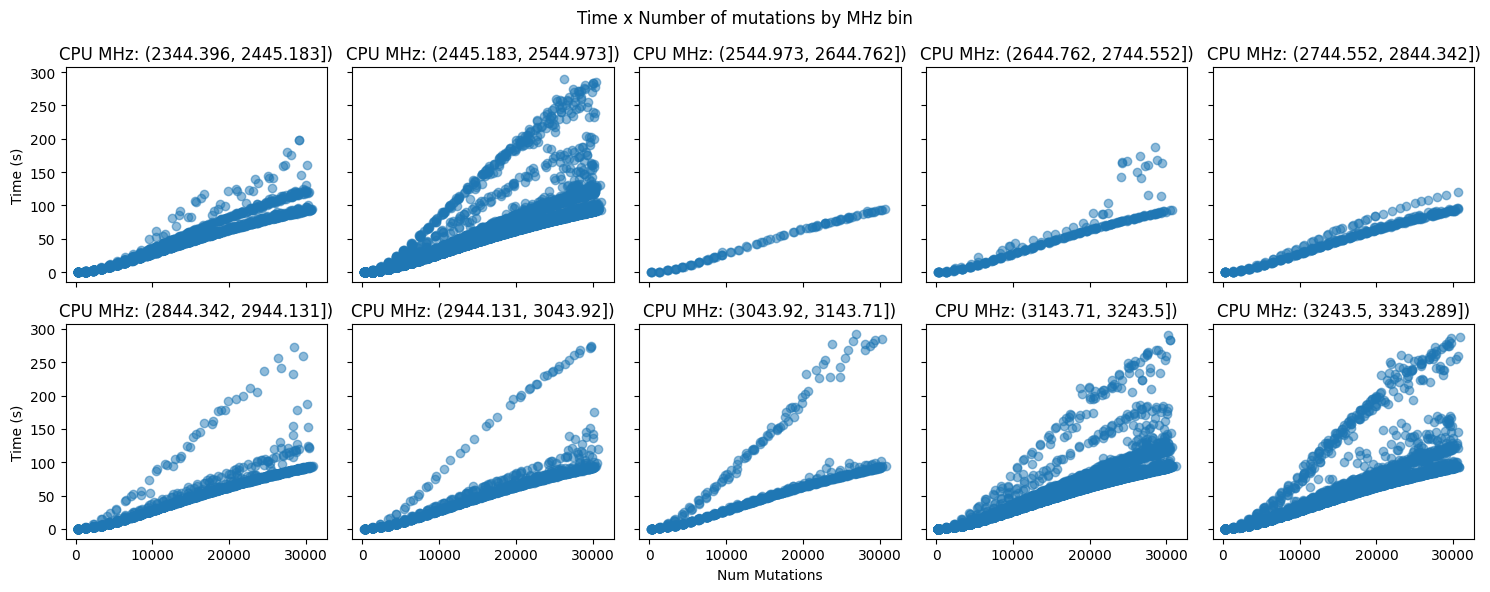

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharey=True, sharex=True)
axes = axes.flatten()
for i, (bin, df) in enumerate(
    tree_stats.join(cpu_mhz)[site].groupby("bin", observed=True)
):
    axes[i].scatter(df.num_mutations, df.timing_result, alpha=0.5)
    axes[i].set_title(f"CPU MHz: {bin})")
axes[0].set_ylabel("Time (s)")
axes[5].set_ylabel("Time (s)")
axes[7].set_xlabel("Num Mutations")
plt.suptitle("Time x Number of mutations by MHz bin")
fig.tight_layout()

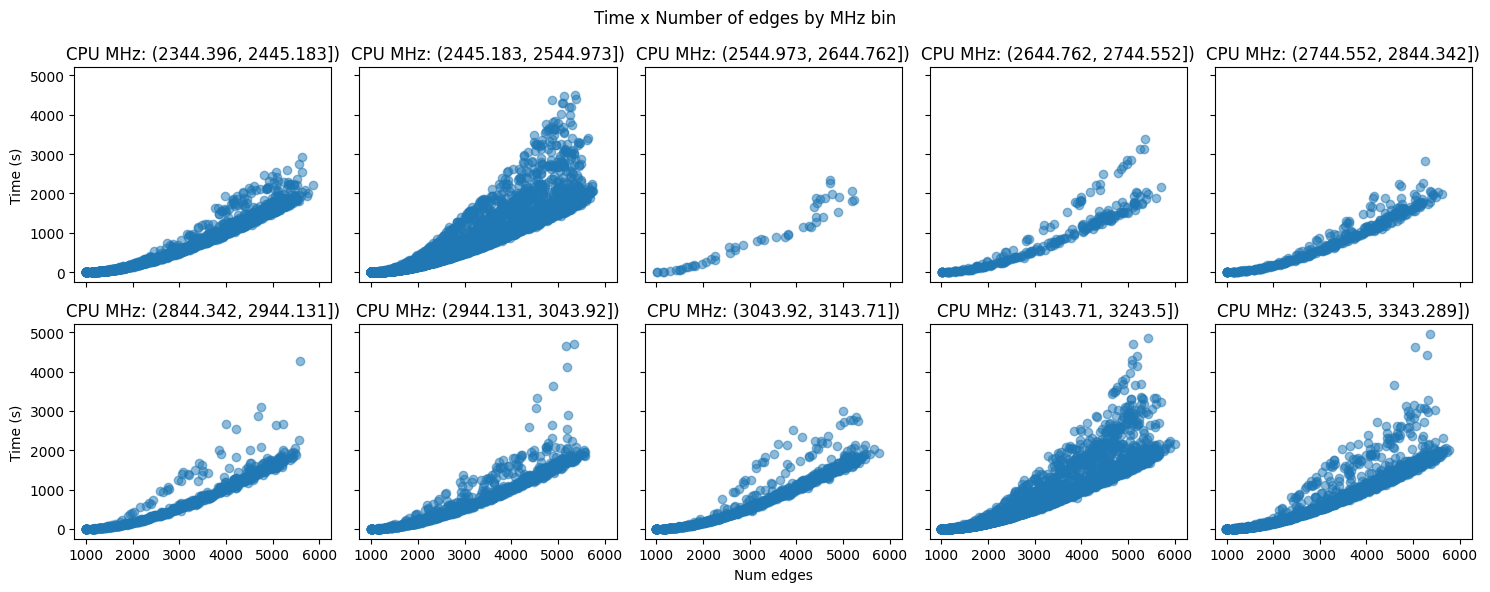

In [27]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharey=True, sharex=True)
axes = axes.flatten()
for i, (bin, df) in enumerate(
    tree_stats.join(cpu_mhz)[branch].groupby("bin", observed=True)
):
    axes[i].scatter(df.num_edges, df.timing_result, alpha=0.5)
    axes[i].set_title(f"CPU MHz: {bin})")
axes[0].set_ylabel("Time (s)")
axes[5].set_ylabel("Time (s)")
axes[7].set_xlabel("Num edges")
plt.suptitle("Time x Number of edges by MHz bin")
fig.tight_layout()